In [1]:
from typing import List, Tuple, Dict, Any, Union
import random
import math

In [2]:
class Matrix:
    def __init__(self, matrix):
      """
      Инициализирует разреженную матрицу.

      :param matrix: Матрица списком.
      """
      self.rows = len(matrix)
      self.cols = len(matrix[0])

      self.values = []
      self.col_index = []
      self.row_pointers = [0]

      for i in range(len(matrix)):
        for j in range(len(matrix[i])):
          if matrix[i][j] != 0:
            self.values.append(matrix[i][j])
            self.col_index.append(j)
        self.row_pointers.append(len(self.values))

    def __len__(self):
        return self.rows

    def __getitem__(self, idx):
        """
        matrix[i] - плотная i-я строка (нумерация с 0).
        Позволяет затем обращаться как matrix[i][j].
        """
        start = self.row_pointers[idx]
        end = self.row_pointers[idx + 1]
        row = [0.0] * self.cols
        for k in range(start, end):
            col = self.col_index[k]
            row[col] = self.values[k]
        return row

    def trace(self):
      """
      Вычисляет след матрицы (cумма элементов главной диагонали).

      :return: след матрицы.
      """
      trace = 0

      for row_index in range(len(self.row_pointers) - 1):
        start = self.row_pointers[row_index]
        end = self.row_pointers[row_index + 1]

        for i in range(start, end):
          if self.col_index[i] == row_index:
            trace += self.values[i]

      return trace

    def get_element(self, row, col):
      """
      Находит элемент матрицы по списку

      :param row: Индекс строки
      :param col: Индекс столбца

      :return: Значение элемента.
      """
      if row < 1 or col < 1 or row > self.rows or col > self.cols:
        raise IndexError("Индекс(-ы) выходят за пределы матрицы")

      row -= 1
      col -= 1

      start = self.row_pointers[row]
      end = self.row_pointers[row + 1]

      for i in range(start, end):
        if self.col_index[i] == col:
          return self.values[i]

      return 0

    def return_full_matrix(self):
      """
      Возвращает плотную матрицу в виде списка.

      :return: Матрица в виде списка.
      """
      print_matrix = [[0 for _ in range(self.cols)] for _ in range(self.rows)]

      for row_index in range(len(self.row_pointers) - 1):
        start = self.row_pointers[row_index]
        end = self.row_pointers[row_index + 1]

        for i in range(start, end):
          col = self.col_index[i]
          print_matrix[row_index][col] = self.values[i]

      return print_matrix

    def return_csr_matrix(self):
      """
      Возвращает матрицу разреженно-строчном виде.

      :return: Матрица в разреженно-строчном виде.
      """
      return self.values, self.col_index, self.row_pointers

    def determinant(self) -> float:
      """
      Вычисляет определитель матрицы (рекурсивно по минорам).
      """
      if self.rows != self.cols:
        raise ValueError("Невозможно найти определитель для неквадратной матрицы")

      if self.rows == 1:
        return self.values[0] if self.values else 0.0
      if self.rows == 2:
        a = self.get_element(1, 1)
        b = self.get_element(1, 2)
        c = self.get_element(2, 1)
        d = self.get_element(2, 2)
        return a * d - b * c

      det = 0.0
      full = self.return_full_matrix()
      start, end = self.row_pointers[0], self.row_pointers[1]

      for idx in range(start, end):
        col = self.col_index[idx]
        val = self.values[idx]

        minor_dense = []
        for row in full[1:]:
          minor_dense.append([row[j] for j in range(self.cols) if j != col])

        minor = self.__class__(minor_dense)

        sign = -1 if (col % 2) else 1

        det += val * sign * minor.determinant()

      return det

    def multiply(self, other: 'Matrix') -> 'Matrix':
      if self.cols != other.rows:
          raise ValueError("Число столбцов A != числу строк B")

      result = Matrix.__new__(Matrix)
      result.rows, result.cols = self.rows, other.cols
      result.values, result.col_index, result.row_pointers = [], [], [0]

      for i in range(self.rows):
          row_acc = {}
          # проходим по ненулевым в A[i,*]
          for idx1 in range(self.row_pointers[i], self.row_pointers[i+1]):
              j  = self.col_index[idx1]   # кол-во столбцов A == кол-во строк B
              v1 = self.values[idx1]
              # обходим строку j матрицы B
              for idx2 in range(other.row_pointers[j], other.row_pointers[j+1]):
                  k  = other.col_index[idx2]
                  v2 = other.values[idx2]
                  row_acc[k] = row_acc.get(k, 0.0) + v1 * v2
          # заполняем результат i‑й строкой
          for col in sorted(row_acc):
              result.col_index.append(col)
              result.values.append(row_acc[col])
          result.row_pointers.append(len(result.values))

      return result

    def T(self) -> 'Matrix':
      """
      Возвращает транспонированную матрицу
      """
      values, col_index, row_ptrs = [], [], [0]

      for col in range(self.cols):
          for row in range(self.rows):
              val = self.get_element(row + 1, col + 1)
              if val != 0:
                  values.append(val)
                  col_index.append(row)
          row_ptrs.append(len(values))

      trans = Matrix.__new__(Matrix)
      trans.rows, trans.cols = self.cols, self.rows
      trans.values, trans.col_index, trans.row_pointers = (values, col_index, row_ptrs)
      return trans

    def minus_lambda_I(self, lam: float) -> 'Matrix':
      """Возвращает матрицу (A − λI)."""
      full = self.return_full_matrix()
      for i in range(self.rows):
          full[i][i] -= lam
      return Matrix(full)


In [3]:
A_data = [
    [1, 2, 3],
    [0, 1, 4],
    [5, 6, 0],
]
b_data = [[14], [13], [22]]

A = Matrix(A_data)
b = Matrix(b_data)
X = Matrix(A_data)

In [4]:
def gauss_solver(A: Matrix, b: Matrix) -> List[Matrix]:
    """
    Вход:

    A: матрица коэффициентов (n×n). Используется класс Matrix из предыдущей лабораторной работы

    b: вектор правых частей (n×1)
    Выход:

    list[Matrix]: список базисных векторов решения системы
    Raises:

    ValueError: если система несовместна
    """
    n = len(A)
    aug = [A[i] + [b[i][0]] for i in range(n)]
    eps = 1e-12
    pivot_cols = []
    pivot_row = 0

    for col in range(n):
        if pivot_row >= n:
            break
        # Поиск ведущего элемента в текущем столбце
        max_row = pivot_row
        max_val = abs(aug[pivot_row][col])

        for r in range(pivot_row + 1, n):
            if abs(aug[r][col]) > max_val:
                max_val = abs(aug[r][col])
                max_row = r

        if abs(max_val) < eps: # Нулевой столбец - свободная переменная
            continue

        # Swap строк, если нужен ведущий элемент
        if max_row != pivot_row:
            aug[pivot_row], aug[max_row] = aug[max_row], aug[pivot_row]
        pivot_cols.append(col)

        # Нормализация ведущей строки
        piv_val = aug[pivot_row][col]
        for c in range(col, n + 1):
            aug[pivot_row][c] /= piv_val

        # Обнуление элементов ниже ведущего
        for r in range(pivot_row + 1, n):
            factor = aug[r][col]
            if factor != 0:
                for c in range(col, n + 1):
                    aug[r][c] -= factor * aug[pivot_row][c]

        pivot_row += 1

    # Проверка на несовместность
    for r in range(pivot_row, n):
        if abs(aug[r][n]) > eps:
            raise ValueError("Несовместимая система")

    # Индексы свободных переменных
    free_cols = [j for j in range(n) if j not in pivot_cols]

    # Обратный ход для поиска частного решения (если оно есть)
    x_part = [0.0] * n
    if any(abs(aug[r][n]) > eps for r in range(n)):
        for r in range(pivot_row - 1, -1, -1):
            col = pivot_cols[r]
            s = 0.0
            for c in range(col + 1, n):
                s += aug[r][c] * x_part[c]
            x_part[col] = aug[r][n] - s

    solutions = []
    # Добавляем частное решение, если оно не нулевое
    if not all(abs(val) < eps for val in x_part):
        solutions.append(Matrix([[val] for val in x_part]))

    # Генерация базисных векторов для свободных переменных
    for free in free_cols:
        x = [0.0] * n
        x[free] = 1.0
        for r in range(pivot_row - 1, -1, -1):
            col = pivot_cols[r]
            s = 0.0
            for c in range(col + 1, n):
                s += aug[r][c] * x[c]
            x[col] = -s

        solutions.append(Matrix([[val] for val in x]))

    return solutions


solutions = gauss_solver(A, b)

for vec in solutions:
    print(vec.return_full_matrix())



[[8.0], [-3.0], [4.0]]


In [5]:
def center_data(X: Matrix) -> Matrix:
  """
  Вход: матрица данных X (n×m)
  Выход: центрированная матрица X_centered (n×m)
  """
  n = len(X)
  m = len(X[0]) if n > 0 else 0
  # Вычисляем средние значения по каждому столбцу
  means = [sum(X[i][j] for i in range(n)) / n for j in range(m)] if n > 0 else []
  # Вычитаем среднее из каждого элемента
  centered_data = [[(X[i][j] - means[j]) for j in range(m)] for i in range(n)]
  return Matrix(centered_data)

X_centered = center_data(X)
X_centered.return_full_matrix()

[[-1.0, -1.0, 0.6666666666666665],
 [-2.0, -2.0, 1.6666666666666665],
 [3.0, 3.0, -2.3333333333333335]]

In [6]:
def covariance_matrix(X_centered) -> Matrix:
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    n = len(X_centered)
    m = len(X_centered[0]) if n > 0 else 0
    # Несмещённая оценка ковариации, делим на (n-1)
    if n <= 1:
        # Если недостаточно данных, возвращаем матрицу нулей
        return Matrix([[0.0] * m for _ in range(m)])

    C = [[0.0] * m for _ in range(m)]

    for j in range(m):
        for k in range(m):
            s = 0.0
            for i in range(n):
                s += X_centered[i][j] * X_centered[i][k]
            C[j][k] = s / (n - 1)

    return Matrix(C)

C = covariance_matrix(X_centered)
C.return_full_matrix()

[[7.0, 7.0, -5.5], [7.0, 7.0, -5.5], [-5.5, -5.5, 4.333333333333334]]

In [7]:
def find_eigenvalues(C: 'Matrix', eps: float = 1e-6) -> List[float]:
    """
    Вход:
    C: матрица ковариаций (m×m)
    eps: допустимая погрешность
    Выход: список вещественных собственных значений
    """
    m = C.rows
    # границы спектра по Гершгорину
    R = max(sum(abs(C.get_element(i+1, j+1)) for j in range(m))
            for i in range(m))
    left, right = -R, R # все лямбды из[−R, R]

    # проходим интервал мелкой сеткой, ищем смены знака детерминанты
    samples = 200
    xs = [left + i*(right-left)/samples for i in range(samples+1)]
    signs = [math.copysign(1, C.minus_lambda_I(x).determinant()) for x in xs]

    roots = []
    for i in range(samples):
        if signs[i] == 0: # точно попали в корень
            roots.append(xs[i])
        elif signs[i] * signs[i+1] < 0: # знак поменялся — внутри корень
            a, b = xs[i], xs[i+1]
            # бисекция
            while b - a > eps:
                mid = (a + b) / 2
                f_mid = C.minus_lambda_I(mid).determinant()
                if f_mid == 0:
                    a = b = mid
                    break
                if math.copysign(1, f_mid) * math.copysign(1, C.minus_lambda_I(a).determinant()) < 0:
                    b = mid
                else:
                    a = mid
            roots.append((a + b) / 2)

    roots.sort(reverse=True)
    return roots

eigen_vals = find_eigenvalues(C)
eigen_vals


[18.324237642288203]

In [8]:
def find_eigenvectors(C: 'Matrix', eigenvalues: List[float]) -> List['Matrix']:
    """
    Вход:

    C: матрица ковариаций (m×m)
    eigenvalues: список собственных значений

    Выход: список собственных векторов (каждый вектор - объект Matrix)
    """
    m = len(C)
    eigenvectors = []
    # Для вычисления собственных векторов используем степень. метод с дефляцией по каждому значению
    A = [C[i][:] for i in range(m)]

    for value in sorted(eigenvalues, reverse=True):
        # Выполняем степенной метод, чтобы получить собственный вектор для текущего собственного значения
        v = [1.0] * m
        norm = math.sqrt(sum(x * x for x in v))

        if norm == 0:
            # нулевой вектор
            eigenvectors.append(Matrix([[0.0] for _ in range(m)]))
            continue

        v = [x / norm for x in v]
        lamb_old = 0.0

        for _ in range(1000):
            w = [0.0] * m
            for i in range(m):
                for j in range(m):
                    w[i] += A[i][j] * v[j]

            norm_w = math.sqrt(sum(x * x for x in w))

            if norm_w < 1e-12:
                break

            v = [x / norm_w for x in w]
            lamb = 0.0

            for j in range(m):
                lamb += v[j] * w[j]

            if abs(lamb - lamb_old) < 1e-6:
                break
            lamb_old = lamb
        # Нормализуем полученный собственный вектор и добавляем в список
        norm_v = math.sqrt(sum(x * x for x in v))
        if norm_v < 1e-12:
            eigenvectors.append(Matrix([[0.0] for _ in range(m)]))
        else:
            eigenvectors.append(Matrix([[x / norm_v] for x in v]))

        # вычитаем вклад найденного собственного вектора
        for i in range(m):
            for j in range(m):
                A[i][j] -= value * v[i] * v[j]

    return eigenvectors

eigen_vecs = find_eigenvectors(C, eigen_vals)
for v in eigen_vecs:
    print(v.return_full_matrix())

[[0.6180203114689289], [0.6180203114689289], [-0.4859030656660815]]


In [9]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    """
    Вход:

    eigenvalues: список собственных значений
    k: число компонент

    Выход: доля объяснённой дисперсии
    """
    if not eigenvalues:
        return 0.0

    total_variance = sum(eigenvalues)

    if total_variance == 0:
        return 0.0

    return sum(sorted(eigenvalues, reverse=True)[:k]) / total_variance

ratio_k2 = explained_variance_ratio(eigen_vals, k=2)
ratio_k2

1.0

In [10]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    """
    Вход: проекция данных X_proj (n×2)
    Выход: объект Figure из Matplotlib
    """
    fig = Figure()
    ax = fig.add_subplot(1, 1, 1)

    # Проверяем, что есть две компоненты для отображения
    if len(X_proj) == 0 or len(X_proj[0]) < 2:
        return fig

    x_coords = [X_proj[i][0] for i in range(len(X_proj))]
    y_coords = [X_proj[i][1] for i in range(len(X_proj))]
    ax.scatter(x_coords, y_coords)
    ax.set_title("PCA Projection")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    return fig


In [11]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    """
    Вход:

    X_orig: исходные данные (n×m)
    X_recon: восстановленные данные (n×m)

    Выход: среднеквадратическая ошибка MSE
    """
    n = len(X_orig)
    m = len(X_orig[0]) if n > 0 else 0

    if n == 0 or m == 0:
        return 0.0

    mse = 0.0

    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            mse += diff * diff
    # Нормируем на количество элементов n*m
    mse /= (n * m)
    return mse

mse_self = reconstruction_error(X, X)
mse_self

0.0

In [12]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Вход:

    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии

    Выход: оптимальное число главных компонент k
    """
    if not eigenvalues:
        return 0

    total_variance = sum(eigenvalues)
    if total_variance == 0:
        return 0

    cumulative = 0.0
    # Сортируем собственные значения по убыванию на всякий случай
    sorted_vals = sorted(eigenvalues, reverse=True)
    for i, val in enumerate(sorted_vals, start=1):
        cumulative += val
        if cumulative / total_variance >= threshold:
            return i

    return len(sorted_vals)

k_auto = auto_select_k(eigen_vals, threshold=0.90)
k_auto

1

In [30]:
def pca(X: 'Matrix', k: int) -> Tuple['Matrix', float]:
    """
    Вход:

    X: матрица данных (n×m)
    k: число главных компонент

    Выход: кортеж (проекция данных, доля объяснённой дисперсии)
    """
    # 1. Центрирование данных
    X_centered = center_data(X)
    # 2. Матрица ковариаций
    C = covariance_matrix(X_centered)
    # 3. Собственные значения и векторы ковариационной матрицы
    eigenvalues = find_eigenvalues(C)
    eigenvectors = find_eigenvectors(C, eigenvalues)

    # Отсортируем собственные значения и векторы по убыванию значений
    idx_sorted = sorted(range(len(eigenvalues)), key=lambda i: eigenvalues[i], reverse=True)
    eigenvalues_sorted = [eigenvalues[i] for i in idx_sorted]
    eigenvectors_sorted = [eigenvectors[i] for i in idx_sorted]

    # 4. Проекция данных на первые k главных компонент
    k = min(k, len(eigenvalues_sorted))
    m = len(eigenvectors_sorted[0]) if eigenvectors_sorted else 0
    # Собираем матрицу V_k из первых k собственных векторов
    V_k = Matrix([[eigenvectors_sorted[j][i][0] for j in range(k)] for i in range(m)])
    n = len(X_centered)
    X_proj_data = [[0.0] * k for _ in range(n)]

    for i in range(n):
        for j in range(k):
            s = 0.0
            for p in range(m):
                s += X_centered[i][p] * V_k[p][j]
            X_proj_data[i][j] = s

    X_proj = Matrix(X_proj_data)
    # Вычисляем долю сохранённой дисперсии для k компонент
    variance_ratio = explained_variance_ratio(eigenvalues_sorted, k)
    return (X_proj, variance_ratio)

X_proj, var_retained = pca(X, k=2)
print("PCA projection:")
print(X_proj.return_full_matrix())
print("Variance ratio:", var_retained)

PCA projection:
[[-1.5599760000485787], [-3.281919688652518], [4.841895688701097]]
Variance ratio: 1.0


In [14]:
def handle_missing_values(X: 'Matrix') -> 'Matrix':
    """
    Вход: матрица данных X (n×m) с возможными NaN
    Выход: матрица данных X_filled (n×m) без NaN
    """
    import math
    n = len(X)
    m = len(X[0]) if n > 0 else 0
    # Вычисляем среднее по каждому столбцу (игнорируя NaN)
    col_means = []

    for j in range(m):
        valid_values = [X[i][j] for i in range(n) if not (isinstance(X[i][j], float) and math.isnan(X[i][j]))]
        if valid_values:
            col_means.append(sum(valid_values) / len(valid_values))
        else:
            col_means.append(0.0)

    # Заполняем NaN средним по соответствующему столбцу
    filled_data = []
    for i in range(n):
        row = []
        for j in range(m):
            if isinstance(X[i][j], float) and math.isnan(X[i][j]):
                row.append(col_means[j])
            else:
                row.append(X[i][j])
        filled_data.append(row)

    return Matrix(filled_data)


X_nan_data = [
    [1.0, float('nan'), 3.0],
    [float('nan'), 1.0, 4.0],
    [5.0, 6.0, float('nan')]
]
X_nan = Matrix(X_nan_data)
X_filled = handle_missing_values(X_nan)
print(X_filled.return_full_matrix())

[[1.0, 3.5, 3.0], [3.0, 1.0, 4.0], [5.0, 6.0, 3.5]]


In [15]:
import random

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1):
    """
    Вход:

    X: матрица данных (n×m)
    noise_level: уровень шума (доля от стандартного отклонения)

    Выход: результаты PCA до и после добавления шума.
    В этом задании можете проявить творческие способности, поэтому выходные данные не типизированы.
    """
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)
    eigen_orig = find_eigenvalues(C)

    # Генерируем зашумленные данные
    n = len(X)
    m = len(X[0]) if n > 0 else 0

    # Вычисляем стандартное отклонение по каждому признаку
    std_devs = []
    for j in range(m):
        col = [X[i][j] for i in range(n)]
        mean_j = sum(col) / n if n > 0 else 0.0
        std = math.sqrt(sum((x - mean_j) ** 2 for x in col) / n) if n > 0 else 0.0
        std_devs.append(std)

    X_noisy_data = []
    for i in range(n):
        noisy_row = []
        for j in range(m):
            # Добавляем гауссов шум с 0 средним и указанным стандартным отклонением
            noise = random.gauss(0, noise_level * std_devs[j] if j < len(std_devs) else 0.0)
            noisy_row.append(X[i][j] + noise)
        X_noisy_data.append(noisy_row)

    X_noisy = Matrix(X_noisy_data)
    # Собственные значения ковариации зашумленных данных
    Xn_centered = center_data(X_noisy)
    C_noisy = covariance_matrix(Xn_centered)
    eigen_noisy = find_eigenvalues(C_noisy)

    return (eigen_orig, eigen_noisy)

eigen_orig, eigen_noisy = add_noise_and_compare(X, noise_level=0.2)
print("original:", eigen_orig)
print("noisy:", eigen_noisy)

original: [18.324237642288203]
noisy: [19.16722621958958, 0.06810037903490462, -4.0232043926258834e-07]


In [27]:
def apply_pca_to_dataset(dataset_name: str, k: int) -> Tuple['Matrix', float]:
    """
    Вход:

    dataset_name: название датасета
    k: число главных компонент

    Выход: кортеж (проекция данных, качество модели)
    """
    import math, csv
    X_data = []
    y = []
    loaded = False
    ds_name = dataset_name.lower()

    try:
        from sklearn import datasets
        if "iris" in ds_name:
            ds = datasets.load_iris()
            X_data = ds.data.tolist()
            y = ds.target.tolist()
            loaded = True
    except Exception:
        loaded = False

    n = len(X_data)
    m = len(X_data[0]) if n > 0 else 0

    X = handle_missing_values(Matrix(X_data))

    indices = list(range(n))
    test_indices = indices
    train_indices = indices
    if n > 1000:
        random.shuffle(indices)
        split = int(0.3 * n)
        test_indices = indices[:split]
        train_indices = indices[split:]

    # Функция 1-NN для предсказания метки класса
    def predict_label(idx, data_matrix, labels, train_idx):
        best_dist = float("inf")
        best_label = None
        for j in train_idx:
            if j == idx:
                continue
            # Евклидово расстояние между объектами idx и j
            dist = 0.0
            for f in range(len(data_matrix[idx])):
                diff = data_matrix[idx][f] - data_matrix[j][f]
                dist += diff * diff
            if dist < best_dist:
                best_dist = dist
                best_label = labels[j]
        return best_label

    # Вычисляем качество модели до снижения размерности
    correct_before = 0
    total_before = 0
    for i in test_indices:
        pred = predict_label(i, X, y, train_indices)
        total_before += 1
        if pred == y[i]:
            correct_before += 1
    accuracy_before = correct_before / total_before if total_before > 0 else 0.0

    X_proj, _ = pca(X, k)

    # Вычисляем качество модели после снижения размерности
    correct_after = 0
    total_after = 0
    for i in test_indices:
        pred = predict_label(i, X_proj, y, train_indices)
        total_after += 1
        if pred == y[i]:
            correct_after += 1
    accuracy_after = correct_after / total_after if total_after > 0 else 0.0

    return (X_proj, accuracy_after)


X_iris_proj, acc_after = apply_pca_to_dataset("iris", k=2)
print("accuracy after PCA:", acc_after)
print("First 5 projected rows:")
print(X_iris_proj.return_full_matrix()[:5])

accuracy after PCA: 0.96
First 5 projected rows:
[[-2.68412547428847, 0.3194138014864192], [-2.7141417715604437, -0.17702137214411523], [-2.888990637890139, -0.14492188919745064], [-2.7453430067969125, -0.31826986391972073], [-2.728716381269734, 0.32679532682379]]


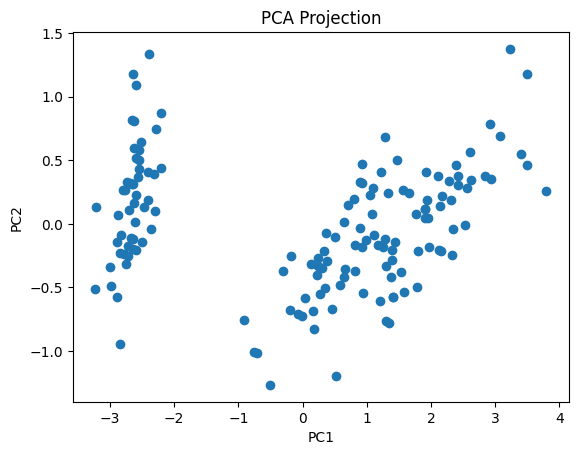

In [25]:
plot_pca_projection(X_iris_proj)

In [31]:
import unittest


globals_ = globals() # удобная ссылка


def dense_to_column(vec_matrix):
    return [row[0] for row in vec_matrix]

def matrix_vector_mul(A: 'Matrix', v):
    res = []
    for i in range(A.rows):
        s = 0.0
        for j in range(A.cols):
            s += A.get_element(i + 1, j + 1) * v[j]
        res.append(s)
    return res


class TestPCAPipeline(unittest.TestCase):

    def test_gauss_solver_consistency(self):
        """Решение gauss_solver должно действительно удовлетворять A·x = b."""
        A = globals_['Matrix']([[2, 1, -1],
                                [-3, -1, 2],
                                [-2, 1, 2]])
        b = globals_['Matrix']([[-3],
                                [ 9],
                                [12]])
        sol_list = globals_['gauss_solver'](A, b)
        x = dense_to_column(sol_list[0])
        Ax = matrix_vector_mul(A, x)
        for got, exp in zip(Ax, dense_to_column(b)):
            self.assertAlmostEqual(got, exp, places=7)

    def test_pca_end_to_end(self):
        """Запускаем полный PCA и убеждаемся, что форма проекции корректна и доля дисперсии адекватна."""
        random.seed(1)

        X_data = [[random.uniform(-5, 5) for _ in range(5)] for _ in range(8)]
        X = globals_['Matrix'](X_data)

        X_proj, gamma = globals_['pca'](X, k=2)
        self.assertEqual(X_proj.rows, 8)
        self.assertEqual(X_proj.cols, 2)
        self.assertGreater(gamma, 0.0)
        self.assertLessEqual(gamma, 1.0)

        Xc = globals_['center_data'](X)
        C = globals_['covariance_matrix'](Xc)
        eig_vals = globals_['find_eigenvalues'](C)
        gamma_ref = globals_['explained_variance_ratio'](eig_vals, 2)
        self.assertAlmostEqual(gamma, gamma_ref, places=6)

    def test_reconstruction_error_zero(self):
        """Ошибка восстановления на тех же данных должна быть нулевой."""
        X = globals_['Matrix']([[1, 2], [3, 4]])
        self.assertAlmostEqual(
            globals_['reconstruction_error'](X, X), 0.0, places=12
        )

    def test_handle_missing_values_and_auto_k(self):
        """После заполнения NaN их быть не должно, а auto_select_k выдаёт корректное k."""
        nan = float('nan')
        X = globals_['Matrix']([[1.0, nan, 3.0],
                                [4.0, 5.0, nan],
                                [nan, 8.0, 9.0]])
        X_filled = globals_['handle_missing_values'](X)
        dense = X_filled.return_full_matrix()
        for row in dense:
            for v in row:
                self.assertFalse(isinstance(v, float) and math.isnan(v))

        C = globals_['covariance_matrix'](globals_['center_data'](X_filled))
        eigs = globals_['find_eigenvalues'](C)
        k95 = globals_['auto_select_k'](eigs, threshold=0.95)
        self.assertGreaterEqual(k95, 1)
        self.assertLessEqual(k95, X_filled.cols)

    def test_apply_pca_to_dataset(self):
        """Сквозной тест: apply_pca_to_dataset на Iris отрабатывает и даёт разумный accuracy."""
        X_proj, acc = globals_['apply_pca_to_dataset']("iris", k=2)
        self.assertEqual(X_proj.cols, 2)
        self.assertEqual(X_proj.rows, 150)
        self.assertGreater(acc, 0.5)



if __name__ == '__main__':
    random.seed(42)
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.428s

OK
